<a href="https://colab.research.google.com/github/brianhphillips/testrepo/blob/main/LightGBM_UsedCars.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# === STEP 1: Import Libraries ===
import kagglehub
import os
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# === STEP 2: Download and Load Dataset ===
path = kagglehub.dataset_download("benjnb/cars-for-sale")
print("Path to dataset files:", path)

data_file = os.path.join(path, "Updated_Car_Sales_Data.csv")
df = pd.read_csv(data_file)

100%|██████████| 828k/828k [00:00<00:00, 92.0MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/benjnb/cars-for-sale/versions/2


In [3]:
# === STEP 3: Explore & Preprocess ===
print(df.head())
print(df.info())
print(df.describe())

# Drop rows with missing target
df = df.dropna(subset=["Price"])

# Fill or drop missing values (customize based on your data)
df = df.fillna("Unknown")

# Identify categorical and numeric features
cat_features = df.select_dtypes(include=["object"]).columns.tolist()
num_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
num_features.remove("Price")  # Remove target from features

# Encode categorical features using LabelEncoder (for simplicity)
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

     Car Make    Car Model  Year  Mileage      Price Fuel Type   Color  \
0     Hyundai       Tucson  2010    52554  44143.820    Hybrid   Black   
1  Land Rover  Range Rover  2016   115056  25414.060    Diesel  Silver   
2       Honda       Accord  2022    18044  28262.872  Electric  Yellow   
3         Kia         Soul  2011    79251  28415.848    Hybrid  Orange   
4  Volkswagen         Golf  2022    40975  31509.792  Electric  Silver   

  Transmission                                   Options/Features Condition  \
0    Automatic                                       Heated Seats      Used   
1       Manual                                                GPS      Used   
2       Manual       Bluetooth, Leather Seats, Backup Camera, GPS  Like New   
3       Manual    Backup Camera, GPS, Heated Seats, Leather Seats       New   
4    Automatic  Leather Seats, Remote Start, Sunroof, Heated S...       New   

  Accident  
0       No  
1       No  
2      Yes  
3      Yes  
4      Yes  
<c

In [4]:
# === STEP 4: Train-Test Split ===
X = df.drop("Price", axis=1)
y = df["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

# === STEP 5: Train LightGBM using callbacks ===
model = LGBMRegressor(
    objective="regression",
    learning_rate=0.1,
    num_leaves=31,
    n_estimators=1000,
    random_state=42
)

model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric="rmse",
    callbacks=[
        early_stopping(stopping_rounds=50),
        log_evaluation(period=50)  # prints log every 50 rounds
    ]
)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001185 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 696
[LightGBM] [Info] Number of data points in the train set: 18400, number of used features: 10
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 46042.263571
Training until validation scores don't improve for 50 rounds
[50]	valid_0's rmse: 26396.8	valid_0's l2: 6.96793e+08
[100]	valid_0's rmse: 26393.1	valid_0's l2: 6.96598e+08
Early stopping, best iteration is:
[67]	valid_0's rmse: 26332.7	valid_0's l2: 6.93413e+08


LGBMRegressor(n_estimators=1000, objective='regression', random_state=42)

In [9]:
# === STEP 6: Evaluation ===
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"\nModel Performance:\nRMSE: {rmse:.2f}\nR² Score: {r2:.4f}")


Model Performance:
RMSE: 26332.73
R² Score: 0.8287


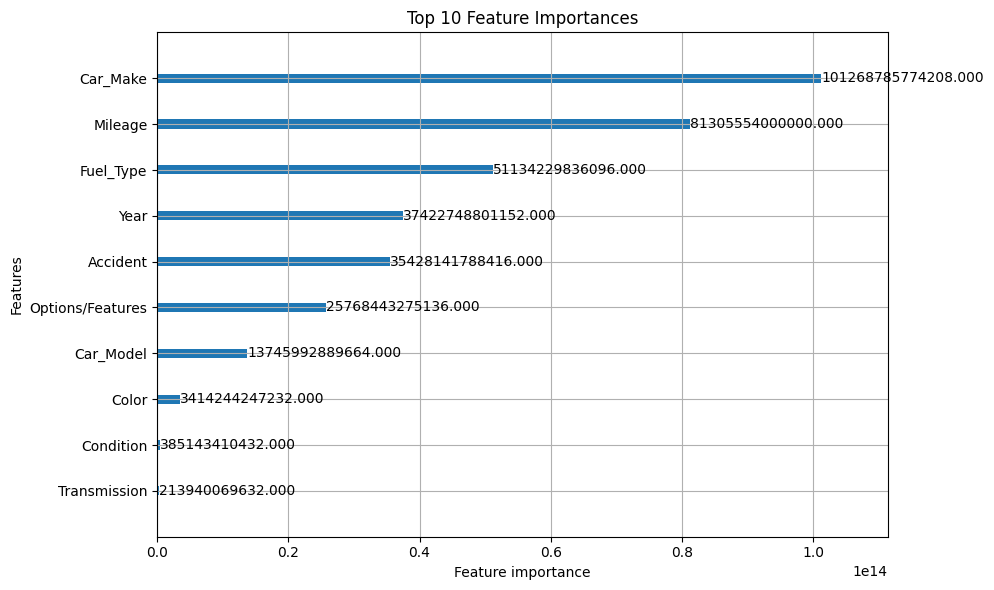

In [10]:
# === STEP 7: Feature Importance ===
lgb.plot_importance(model, max_num_features=10, importance_type="gain", figsize=(10, 6))
plt.title("Top 10 Feature Importances")
plt.tight_layout()
plt.show()